Antes de iniciar, certifique-se que obteve uma maquina com GPU ou TPU




Seguir os passos descritos aqui https://www.kaggle.com/general/74235




In [1]:
! pip install -q kaggle
from google.colab import files 
files.upload() #aqui faz o upload do kaggle.json que voce gerou. Ver link acima.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felipedepauli","key":"2fae4964b8f9ffd726477e7ae33583be"}'}

Baixar e extrair os dados

In [2]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/food41
!unzip food41.zip 

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tac

In [3]:
import os
os.remove('food41.zip')

Separar em treino e teste de acordo com a sugestao do autor

In [4]:
import os
with open('meta/meta/train.txt') as trainfile:
    trainlines = trainfile.readlines()
    trainlines = [line.rstrip()+'.jpg' for line in trainlines]

with open('meta/meta/test.txt') as testfile:
    testlines = testfile.readlines()
    testlines = [line.rstrip()+'.jpg' for line in testlines]

!mkdir train/
!mkdir test/

#create directories
with open('meta/meta/classes.txt') as classfile:
    classlines = classfile.readlines()
    classlines = [line.rstrip() for line in classlines]

for class_ in classlines:
    try:
        os.makedirs('train/'+class_)
    except:
        pass
    try:
        os.makedirs('test/'+class_)
    except:
        pass

#move files to corresponding folder
for tl in trainlines:
    try:
        os.replace('images/'+tl, 'train/'+tl)
    except:
        pass
for tl in testlines:
    try:
        os.replace('images/'+tl, 'test/'+tl)
    except:
        pass

Limpa o que nao vai ser usado

In [5]:
#clean up
for class_ in classlines:
    try:
        os.rmdir('images/'+class_)
    except:
        pass
try:
    os.rmdir('images/')
except:
    pass

Aqui comeca de fato o modelo. O codigo abaixo e apenas uma sugestao.

In [6]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)
valid_datagen = ImageDataGenerator(
        rescale=1./255,
)

In [8]:
batch_size = 128

train_data = train_datagen.flow_from_directory(
    'train/',
    batch_size=batch_size,
    target_size=(224, 224),
    shuffle=True,
)
valid_data = valid_datagen.flow_from_directory(
    'test/',
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [9]:

def visualize_images(images,labels):
    figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 14))
    classes = list(train_data.class_indices.keys())
    img_no = 0
    for i in range(3):
        for j in range(3):
            img = images[img_no]
            lbl = np.argmax(labels[img_no])

            ax[i,j].imshow(img)
            ax[i,j].set_title(classes[lbl])
            ax[i,j].set_axis_off()
            img_no+=1




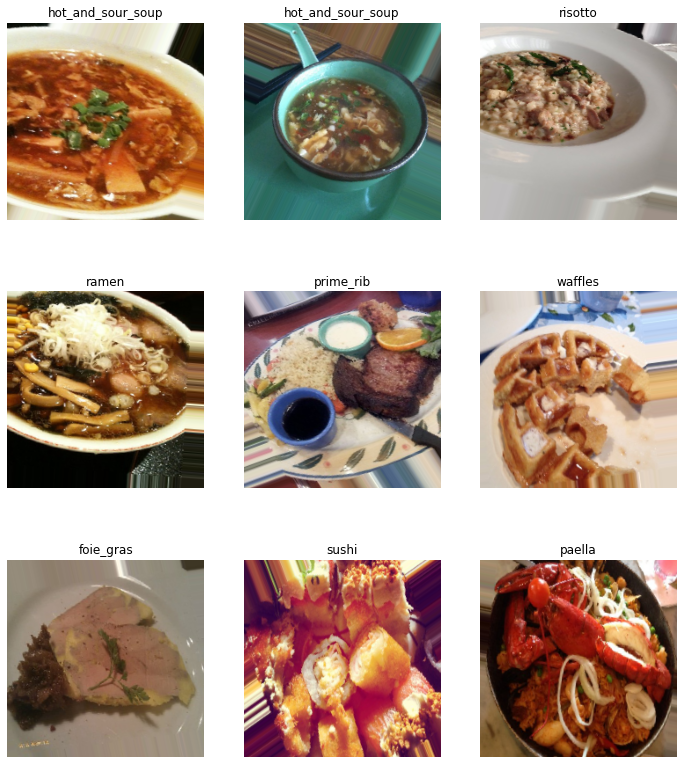

In [10]:
import matplotlib.pyplot as plt
images, labels = next(train_data)
visualize_images(images,labels)



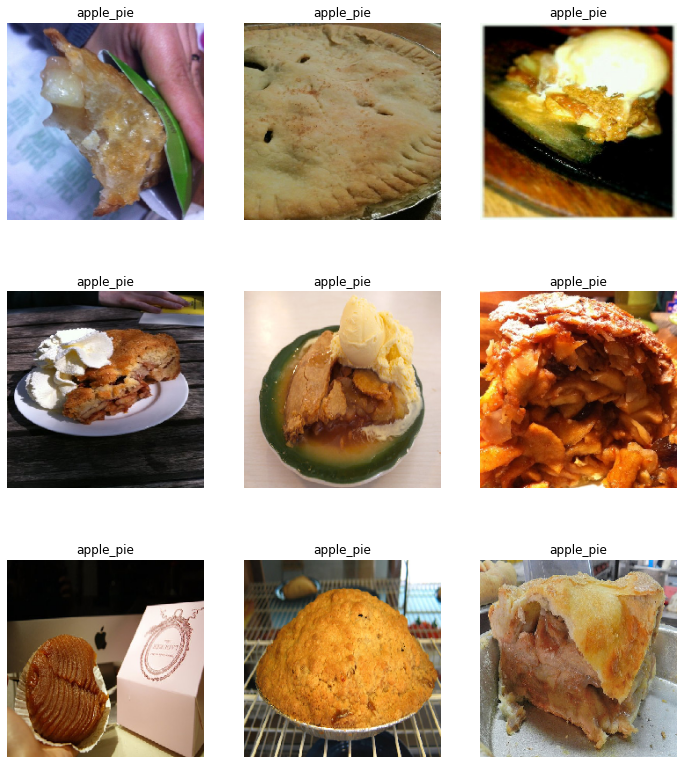

In [11]:
images, labels = next(valid_data)
visualize_images(images,labels)

In [12]:
train_batches = train_datagen.flow_from_directory('train/', batch_size=64, class_mode = 'categorical', target_size=(224, 224))
test_batches = valid_datagen.flow_from_directory('test/', batch_size=64, class_mode = 'categorical', target_size=(224, 224))

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model

In [14]:


base = MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
base.trainable = True
model = Sequential()
model.add(base)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(101, activation='softmax'))
# opt = SGD(lr=0.001, momentum=0.9)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])



9406464/9406464 [==============================] - 0s 0us/step


In [15]:
from datetime import datetime
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
log = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log,write_graph=False,update_freq=100)
chkp = ModelCheckpoint('drive/MyDrive/mobilenetv2_tuned.h5',monitor='val_accuracy',verbose=1,save_best_only=True)



In [16]:


history = model.fit(train_data, 
                    epochs=1,
                    validation_data = valid_data,
                    callbacks=[early_stop, reduce_lr, tensorboard, chkp])





592/592 [==============================] - ETA: 0s - loss: 3.0915 - accuracy: 0.2889
Epoch 1: val_accuracy improved from -inf to 0.02257, saving model to drive/MyDrive/mobilenetv2_tuned.h5
592/592 [==============================] - 1310s 2s/step - loss: 3.0915 - accuracy: 0.2889 - val_loss: 10.8228 - val_accuracy: 0.0226 - lr: 0.0010


In [17]:


preds = model.predict(valid_data)


out = preds.argmax(axis=1)
out.shape




198/198 [==============================] - 110s 553ms/step


(25250,)

In [18]:
from sklearn.metrics import confusion_matrix


images, labels = next(valid_data)
confusion_matrix(labels, preds)

ValueError: ignored

Esta etapa pode gerar um problema. Se o flow from directory detectar mais de 101 classes, possivelmente existem arquivos temporarios do notebook escondidos dentro da pasta. Neste caso remover com !rm -r (train ou test)/.ipynb_checkpoints/